A.S. Lundervold, version 14.01.22

# Introduction

We want to create a system that can classify pictures of fruit. We'll use the Fruits-360 data set: https://www.kaggle.com/moltean/fruits. 

This is a demo of a mini-project done at the very start of DAT255. Therefore, we'll only use techniques and ideas covered by Module 1 of the course. Feel free to come back to this project later in the course. You'll see that you're then able to bring many additional techniques and tricks to the problem. 

We split the project into four notebooks: 

1. `1.0-asl-collect_and_explore_data.ipynb`: This is the current notebook. Here we'll download and inspect the Fruits-360 data set
2. `2.0-asl-fruit_classifier.ipynb`: Here we'll design and train our fruit classifier model, and evaluate its performance
3. `3.1-asl-fruit_classifer_app-v1.ipynb`: This notebook makes a first attempt at making an application out of what we've constructed
4. `3.2-asl-fruit_classifer_app-v2.ipynb`: We'll deploy this notebook to Binder to make the application publicly accessible


> <span style="color: green;"> There will be some comments that are a bit different than those one would make if this was a real mini-project completed at the current stage of the course. These are written in green, like this. </span>

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on 
# Google Colaboratory, as that makes some difference for the code below.

if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

The notebook is not running on Colab. colab=False.


In [2]:
if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()
    from fastbook import *

In [3]:
%matplotlib inline
from fastai.vision.all import *
from pathlib import Path

In [4]:
if colab:
    DATA = Path('/content/gdrive/MyDrive/DAT255/fruits-360')
    DATA.mkdir(exist_ok=True, parents=True)
if not colab:
    # Set this to where you want to download the image data
    DATA = Path('/home/alex/data-tmp/fruits-360')
    DATA.mkdir(exist_ok=True)

# Get the data

The Fruits-360 data set is available on Kaggle: https://www.kaggle.com/moltean/fruits. 

> We'll use the Kaggle API to download the data. It requires a manual step to download your API Token from Kaggle. See here for instructions https://github.com/Kaggle/kaggle-api. 

If you're using Colab, upload the `kaggle.json` file here:

> The following cell may exit with an error if you're using Firefox: https://stackoverflow.com/questions/48760475/not-able-to-upload-local-files-in-google-colab. In that case, you can switch to another browser or find another way to upload the kaggle.json file (f.ex. to your Google Drive). 

In [5]:
if colab:
    from google.colab import files
    uploaded = files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle
    !chmod 600 ~/.kaggle/kaggle.json

In [6]:
import os

In [7]:
if not os.path.isfile(DATA/'fruits.zip'):
    !kaggle datasets download -d moltean/fruits -p $DATA

In [8]:
# Warning: on Colab this will take a while. Make sure 
# that the extraction process completes. If not, you may 
# have to retry by removing the "if not ..." check and 
# rerunning the cell
import shutil
if not os.path.exists(DATA/'fruits-360_dataset'):
    shutil.unpack_archive(DATA/'fruits.zip', extract_dir=DATA)

In [9]:
DATA.ls()

(#3) [Path('/home/alex/data-tmp/fruits-360/fruits.zip'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset')]

# Basic exploration: what did we just download?

We see that there are two folders that seem to contain the data. We'll have to investigate further to see what we can/should use.

In [10]:
if not colab:
    !tree -L 3 $DATA

/home/alex/data-tmp/fruits-360
├── fruits-360_dataset
│   └── fruits-360
│       ├── LICENSE
│       ├── models
│       ├── papers
│       ├── readme.md
│       ├── Test
│       ├── test-multiple_fruits
│       └── Training
├── fruits-360-original-size
│   └── fruits-360-original-size
│       ├── Meta
│       ├── Papers
│       ├── readme.md
│       ├── Test
│       ├── Training
│       └── Validation
└── fruits.zip

14 directories, 4 files


Let's check what's in the `fruits-360_dataset` folder:

In [11]:
(DATA/'fruits-360_dataset').ls()

(#1) [Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360')]

...another folder

In [12]:
(DATA/'fruits-360_dataset'/'fruits-360').ls()

(#7) [Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/LICENSE'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/models'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/papers'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/test-multiple_fruits'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/readme.md'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training')]

..we need to dig deeper:

In [13]:
(DATA/'fruits-360_dataset'/'fruits-360'/'Training').ls()

(#131) [Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Apple Granny Smith'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Tomato not Ripened'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Apple Golden 1'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Pepper Red'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Pomelo Sweetie'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 4'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Banana Lady Finger'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Grape White 3'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Apple Red Yellow 1')...]

There we go! Now we seem to have found the images, organized into different classes. 

Let's take a look at a couple:

In [14]:
path = DATA/'fruits-360_dataset'/'fruits-360'

In [15]:
(path/'Training'/'Mango Red').ls()

(#426) [Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/215_100.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/92_100.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_118_100.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/152_100.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_126_100.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/157_100.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_127_100.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_136_100.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/136_100.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red

Here's one:

In [16]:
test_img = (path/'Training'/'Mango Red').ls()[0]
test_img

Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/215_100.jpg')

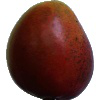

In [17]:
img = load_image(test_img)
img

Let's check its shape

In [18]:
img.shape

(100, 100)

Here's a couple:

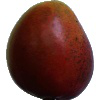

(100, 100)
########################################


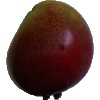

(100, 100)
########################################


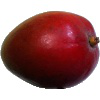

(100, 100)
########################################


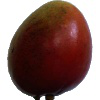

(100, 100)
########################################


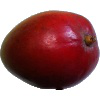

(100, 100)
########################################


In [19]:
for img in (path/'Training'/'Mango Red').ls()[:5]:
    img = load_image(img)
    display(img)
    print(img.shape)
    print("#"*40)

What about the other folder?

In [20]:
DATA.ls()

(#3) [Path('/home/alex/data-tmp/fruits-360/fruits.zip'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset')]

In [21]:
(DATA/'fruits-360-original-size').ls()

(#1) [Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size')]

In [22]:
(DATA/'fruits-360-original-size'/'fruits-360-original-size').ls()

(#6) [Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Meta'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Test'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Validation'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/readme.md'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Papers'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training')]

In [23]:
(DATA/'fruits-360-original-size'/'fruits-360-original-size'/'Training').ls()

(#24) [Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_golden_2'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/zucchini_1'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_crimson_snow_1'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/cucumber_3'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_3'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/pear_3'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_golden_1'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_2'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red

In the `fruits-360_dataset` folder we had more classes than this..

Let's look at a few images and their dimensions:

In [24]:
path = DATA/'fruits-360-original-size'/'fruits-360-original-size'/'Training'

In [25]:
(path/'apple_red_1').ls()

(#309) [Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_246.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_182.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_76.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_130.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r1_306.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r1_142.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_288.jpg'),Path('/home/alex/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_94.jpg'),Path('/home/alex/data-tmp/

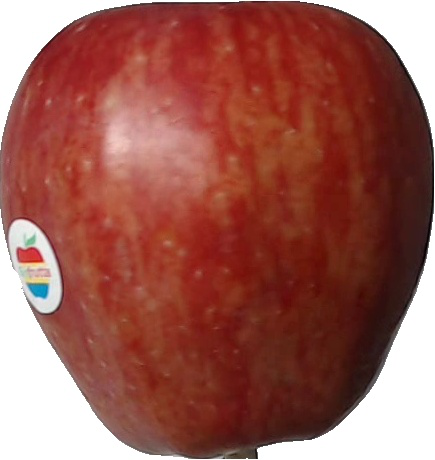

(460, 435)
########################################


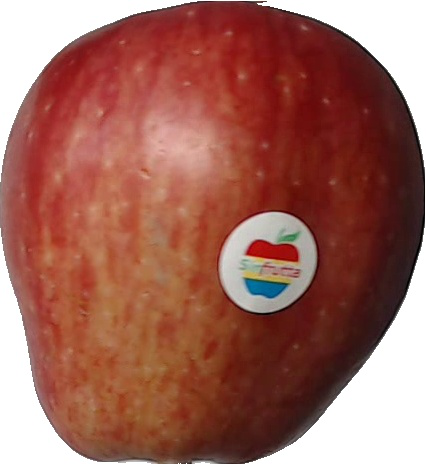

(465, 426)
########################################


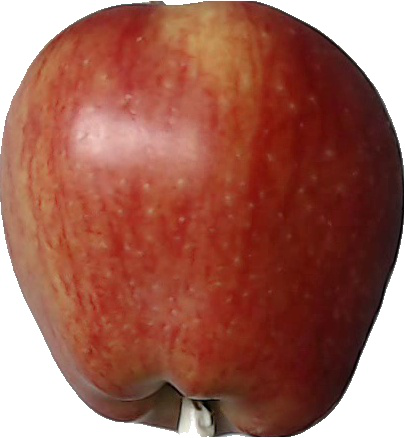

(438, 405)
########################################


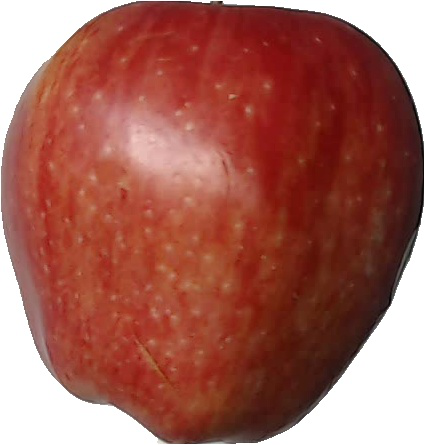

(445, 425)
########################################


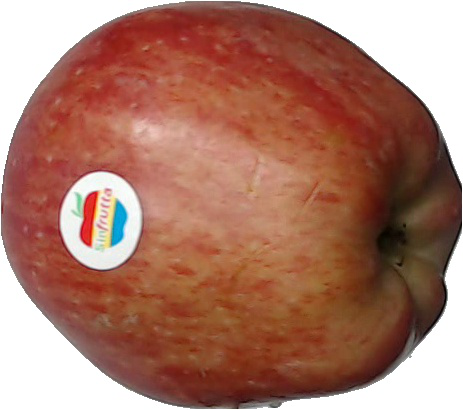

(410, 463)
########################################


In [26]:
for img in (path/'apple_red_1').ls()[:5]:
    img = load_image(img)
    display(img)
    print(img.shape)
    print("#"*40)

Much fewer, but also much larger images, of varying sizes..

> We choose to look at the larger data set of smaller images in what follows. Feel free to explore what you can do with the other data set.

In [27]:
path = DATA/'fruits-360_dataset'/'fruits-360'

# More exploration of the data set

Here are some natural questions that we'd like answered: 

>How many training and test images? How many images of each class of fruit in the two sets? Are all classes represented in both training and test?

In [28]:
path.ls()

(#7) [Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/LICENSE'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/models'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/papers'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/test-multiple_fruits'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/readme.md'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training')]

In [29]:
(path/'Training').ls()

(#131) [Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Apple Granny Smith'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Tomato not Ripened'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Apple Golden 1'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Pepper Red'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Pomelo Sweetie'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Tomato 4'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Banana Lady Finger'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Grape White 3'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Apple Red Yellow 1')...]

In [30]:
(path/'Test').ls()

(#131) [Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Apple Granny Smith'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Tomato not Ripened'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Apple Golden 1'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Pepper Red'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Pomelo Sweetie'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Tomato 4'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Banana Lady Finger'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Mango Red'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Grape White 3'),Path('/home/alex/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Apple Red Yellow 1')...]

In [31]:
from pathlib import PurePath

In [32]:
def get_class_distribution(path):
    classes = [PurePath(c).parts[-1] for c in path.glob('*')]
    nb_per_class = {c:len(list((path/c).iterdir())) for c in classes}
    
    print(f"There are {len(classes)} classes in the data set")
    
    return nb_per_class

In [33]:
nb_per_class_train = get_class_distribution(path/'Training')

There are 131 classes in the data set


In [34]:
nb_per_class_test = get_class_distribution((path/'Test'))

There are 131 classes in the data set


In [35]:
nb_per_class_train

{'Apple Granny Smith': 492,
 'Tomato not Ripened': 474,
 'Apple Golden 1': 480,
 'Pepper Red': 666,
 'Pomelo Sweetie': 450,
 'Tomato 4': 479,
 'Banana Lady Finger': 450,
 'Mango Red': 426,
 'Grape White 3': 492,
 'Apple Red Yellow 1': 492,
 'Lemon': 492,
 'Mandarine': 490,
 'Chestnut': 450,
 'Ginger Root': 297,
 'Guava': 490,
 'Apple Pink Lady': 456,
 'Nut Pecan': 534,
 'Grape Pink': 492,
 'Banana': 490,
 'Tomato 3': 738,
 'Pear 2': 696,
 'Pear Stone': 711,
 'Tamarillo': 490,
 'Avocado': 427,
 'Nut Forest': 654,
 'Pineapple Mini': 493,
 'Salak': 490,
 'Carambula': 490,
 'Apple Crimson Snow': 444,
 'Pear Williams': 490,
 'Clementine': 490,
 'Onion Red': 450,
 'Redcurrant': 492,
 'Onion White': 438,
 'Limes': 490,
 'Pepino': 490,
 'Rambutan': 492,
 'Blueberry': 462,
 'Apple Red 3': 429,
 'Apple Golden 2': 492,
 'Kohlrabi': 471,
 'Kumquats': 490,
 'Pear Red': 666,
 'Melon Piel de Sapo': 738,
 'Tomato Cherry Red': 492,
 'Apple Braeburn': 492,
 'Cucumber Ripe 2': 468,
 'Walnut': 735,
 'Cher

In [36]:
nb_per_class_test

{'Apple Granny Smith': 164,
 'Tomato not Ripened': 158,
 'Apple Golden 1': 160,
 'Pepper Red': 222,
 'Pomelo Sweetie': 153,
 'Tomato 4': 160,
 'Banana Lady Finger': 152,
 'Mango Red': 142,
 'Grape White 3': 164,
 'Apple Red Yellow 1': 164,
 'Lemon': 164,
 'Mandarine': 166,
 'Chestnut': 153,
 'Ginger Root': 99,
 'Guava': 166,
 'Apple Pink Lady': 152,
 'Nut Pecan': 178,
 'Grape Pink': 164,
 'Banana': 166,
 'Tomato 3': 246,
 'Pear 2': 232,
 'Pear Stone': 237,
 'Tamarillo': 166,
 'Avocado': 143,
 'Nut Forest': 218,
 'Pineapple Mini': 163,
 'Salak': 162,
 'Carambula': 166,
 'Apple Crimson Snow': 148,
 'Pear Williams': 166,
 'Clementine': 166,
 'Onion Red': 150,
 'Redcurrant': 164,
 'Onion White': 146,
 'Limes': 166,
 'Pepino': 166,
 'Rambutan': 164,
 'Blueberry': 154,
 'Apple Red 3': 144,
 'Apple Golden 2': 164,
 'Kohlrabi': 157,
 'Kumquats': 166,
 'Pear Red': 222,
 'Melon Piel de Sapo': 246,
 'Tomato Cherry Red': 164,
 'Apple Braeburn': 164,
 'Cucumber Ripe 2': 156,
 'Walnut': 249,
 'Cherr

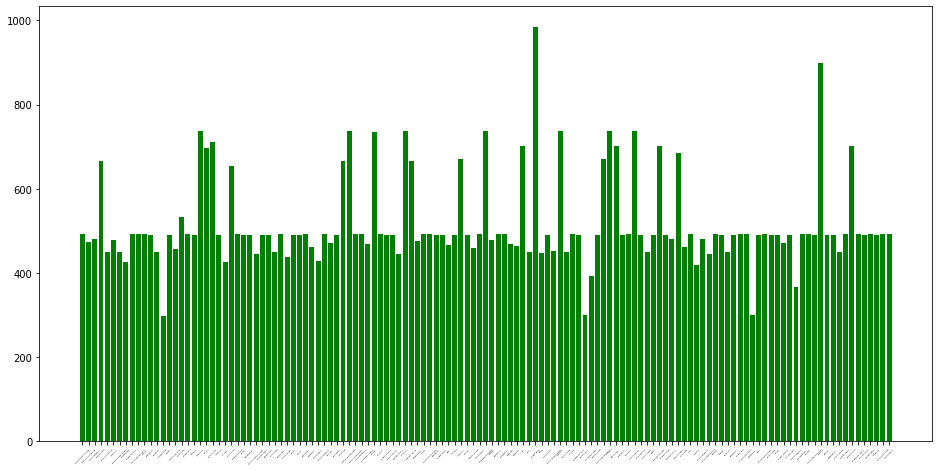

In [37]:
plt.figure(figsize=(16,8))
plt.bar(nb_per_class_train.keys(), nb_per_class_train.values(), color='g')
plt.xticks(rotation=45, fontsize=2)
plt.show()

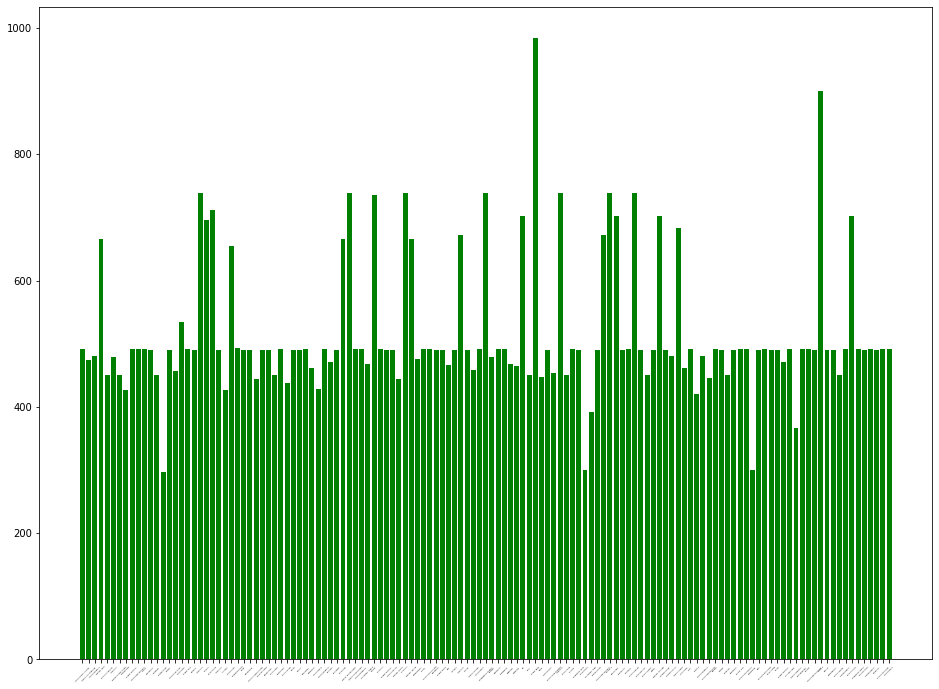

In [38]:
plt.figure(figsize=(16,12))
plt.bar(nb_per_class_test.keys(), nb_per_class_train.values(), color='g')
plt.xticks(rotation=45, fontsize=2)
plt.show()

# What have we learned so far? What's next?

It seems that we can use the data stored in the folder `DATA/fruits-360_dataset/fruits-360`. The labels for each picture of a fruit can be extracted from the name of its parent folder. 

Next: let's try to turn this into a fastai data set and create fastai data loaders. Then we should be able to train and evaluate a classifier, just as for the pictures of dogs and cats from Module 1.